In [1]:
import sys
import os
# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
# Loading Config
from utils.config import load_yaml_config, merge_configs, dict_to_namespace
import numpy as np

default_yaml = "../utils/configs/default.yaml"
problem_yaml = "../utils/configs/problem_3.yaml"
category_yaml = "../utils/configs/experiment_trnc_c.yaml"

custom_config_files = [default_yaml, problem_yaml, category_yaml] # Add more config files if needed
configs = [load_yaml_config(config_file) for config_file in custom_config_files]
yaml = merge_configs(*configs)

## Here you can modify the yaml object to change the configuration
## Example: yaml.seed = 123, yaml.max_num_tasks = 10
config = dict_to_namespace(yaml)

In [3]:
# config.invalid_action_replacement = True

In [4]:
config.train = False
config.evaluate = True

In [5]:
from env.cades_env import CadesEnv
from stable_baselines3.common.env_checker import check_env

#xs Initialize and check the environment
env = CadesEnv(config)
check_env(env)

In [ ]:
from models.ppo import PPOModel

model_url = "../../experiments/models/p3/trnc_c/early_term_1000"
# model_url = "../mlruns/304206841489822493/8113f929570e45b489b2e7395b9d5873/artifacts/models/epoch_1000"
model = PPOModel.load(model_url, env, config)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
from env.extended_states_generator import ExtendedStatesGenerator
import copy

def change_states(env, num_tasks):
    
    new_config = copy.deepcopy(config)
    new_config.max_num_tasks = num_tasks
    new_config.min_num_tasks = num_tasks
    if num_tasks < 2:
        new_config.min_num_comms = 0
        new_config.max_num_comms = 0
    else:
        new_config.min_num_comms = num_tasks // 2
        new_config.max_num_comms = num_tasks // 2
        new_config.max_comm_chain = config.min_node_size // config.min_task_size
    if num_tasks < 3:
        new_config.number_of_critical_tasks = 0
        new_config.number_of_replicas = 0
    else:
        new_config.number_of_critical_tasks = num_tasks // 4
        new_config.number_of_replicas = 2
    old_generator = env.states_generator
    env.states_generator = ExtendedStatesGenerator(new_config, env)
    # Use the new state generator to generate the states
    states = env.generate_states(training=False)

    if(env.config.max_num_tasks != env.states_generator.max_num_tasks): # If the state generator did not generate the maximum number of tasks
        ## Pad the states to the maximum number of tasks
        indices_to_pad = env.config.max_num_tasks - env.states_generator.max_num_tasks
        padded_tasks = np.pad(states['tasks'], (0, indices_to_pad), mode='constant')
        padded_critical_mask = np.pad(states['critical_mask'], (0, indices_to_pad), mode='constant')
        padded_communications = np.pad(states['communications'], ((0, indices_to_pad), (0, indices_to_pad)), mode='constant')
        states['tasks'] = padded_tasks
        states['critical_mask'] = padded_critical_mask
        states['communications'] = padded_communications
    
    # Restore the old state generator
    env.states_generator = old_generator
    return states

In [8]:
episodes = 100
global_states = {}
for num_tasks in range(1, env.config.max_num_tasks + 1):
    for num_episode in range(episodes): # 100 episode states for each number of tasks
        states = change_states(env, num_tasks)
        global_states[(num_tasks, num_episode)] = states

In [9]:
def evaluate_model(model, num_tasks, states, heuristic=None):
    results = {
        'success': 0, 
        'inference_time': 0, 
        'avg_active_node_occupancy': 0,
        'message_channel_occupancy': 0,
        'empty_nodes': 0
    }
    for num_episode in range(episodes):
        if heuristic is not None:
            heuristic.set_state(states[(num_tasks, num_episode)])
        result = model.evaluate(states=states[(num_tasks, num_episode)])
        if result['termination_cause'] == 'success':
            results['success'] += 1
        results['inference_time'] += result['inference_time']
        results['avg_active_node_occupancy'] += result['metrics']['avg_active_node_occupancy']
        results['message_channel_occupancy'] += result['metrics']['message_channel_occupancy']
        results['empty_nodes'] += result['metrics']['empty_nodes']
        # print(f"Episode {num_episode + 1} completed, Success: {result['termination_cause']}, Inference Time: {round(result['inference_time'] * 1000, 2)}, Avg Active Node Occupancy: {result['metrics']['avg_active_node_occupancy']}, Message Channel Occupancy: {result['metrics']['message_channel_occupancy']}, Empty Nodes: {result['metrics']['empty_nodes']}")
    # Average the rewards

    results['success'] = round(results['success'] / episodes * 100, 2)
    results['inference_time'] = round(results['inference_time'] / episodes * 1000, 2)
    results['avg_active_node_occupancy'] = round(results['avg_active_node_occupancy'] / episodes, 2)
    results['message_channel_occupancy'] = round(results['message_channel_occupancy'] / episodes, 2)
    results['empty_nodes'] = round(results['empty_nodes'] / episodes, 2)
    return results

In [10]:
model_predict = model.model.predict

In [11]:
import pandas as pd
metrics = pd.DataFrame(columns=['ppo', 'ffd', 'nf', 'ff'])
model.model.predict = model_predict
values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")
    
metrics['ppo'] = values

Number of tasks: 1, Inference Time: 2.41 ms, Success Rate: 97.0, Avg Active Node Occupancy: 41.23, Message Channel Occupancy: 0.0, Empty Nodes: 86.28
Number of tasks: 2, Inference Time: 3.21 ms, Success Rate: 99.0, Avg Active Node Occupancy: 43.89, Message Channel Occupancy: 100.0, Empty Nodes: 71.31
Number of tasks: 3, Inference Time: 4.78 ms, Success Rate: 99.0, Avg Active Node Occupancy: 44.87, Message Channel Occupancy: 100.0, Empty Nodes: 56.9
Number of tasks: 4, Inference Time: 6.4 ms, Success Rate: 99.0, Avg Active Node Occupancy: 44.37, Message Channel Occupancy: 99.5, Empty Nodes: 42.65
Number of tasks: 5, Inference Time: 7.94 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.25, Message Channel Occupancy: 100.0, Empty Nodes: 27.2
Number of tasks: 6, Inference Time: 9.48 ms, Success Rate: 99.0, Avg Active Node Occupancy: 45.41, Message Channel Occupancy: 99.0, Empty Nodes: 15.61
Number of tasks: 7, Inference Time: 11.01 ms, Success Rate: 97.0, Avg Active Node Occupancy: 4

In [12]:
# redefine model's predict method to use the heuristic
from heuristics.ffd import FirstFitDecreasingHeuristic
heuristic = FirstFitDecreasingHeuristic(env)
model.model.predict = heuristic.predict

values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states, heuristic)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")

metrics['ffd'] = values

Number of tasks: 1, Inference Time: 0.11 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.76, Message Channel Occupancy: 0.0, Empty Nodes: 85.78
Number of tasks: 2, Inference Time: 0.2 ms, Success Rate: 100.0, Avg Active Node Occupancy: 77.71, Message Channel Occupancy: 26.0, Empty Nodes: 81.86
Number of tasks: 3, Inference Time: 0.24 ms, Success Rate: 100.0, Avg Active Node Occupancy: 67.67, Message Channel Occupancy: 71.0, Empty Nodes: 70.5
Number of tasks: 4, Inference Time: 0.38 ms, Success Rate: 100.0, Avg Active Node Occupancy: 59.37, Message Channel Occupancy: 84.5, Empty Nodes: 56.52
Number of tasks: 5, Inference Time: 0.43 ms, Success Rate: 100.0, Avg Active Node Occupancy: 71.36, Message Channel Occupancy: 79.5, Empty Nodes: 52.7
Number of tasks: 6, Inference Time: 0.48 ms, Success Rate: 100.0, Avg Active Node Occupancy: 78.09, Message Channel Occupancy: 86.67, Empty Nodes: 49.49
Number of tasks: 7, Inference Time: 0.53 ms, Success Rate: 100.0, Avg Active Node Occupancy

In [13]:
# redefine model's predict method to use the heuristic
from heuristics.ff import FirstFitHeuristic
heuristic = FirstFitHeuristic(env)
model.model.predict = heuristic.predict

values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states, heuristic)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")

metrics['ff'] = values

Number of tasks: 1, Inference Time: 0.1 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.76, Message Channel Occupancy: 0.0, Empty Nodes: 85.78
Number of tasks: 2, Inference Time: 0.2 ms, Success Rate: 100.0, Avg Active Node Occupancy: 77.69, Message Channel Occupancy: 26.0, Empty Nodes: 81.86
Number of tasks: 3, Inference Time: 0.25 ms, Success Rate: 100.0, Avg Active Node Occupancy: 67.73, Message Channel Occupancy: 63.0, Empty Nodes: 70.5
Number of tasks: 4, Inference Time: 0.39 ms, Success Rate: 100.0, Avg Active Node Occupancy: 59.35, Message Channel Occupancy: 80.5, Empty Nodes: 56.35
Number of tasks: 5, Inference Time: 0.38 ms, Success Rate: 100.0, Avg Active Node Occupancy: 71.49, Message Channel Occupancy: 79.5, Empty Nodes: 52.93
Number of tasks: 6, Inference Time: 0.48 ms, Success Rate: 100.0, Avg Active Node Occupancy: 74.76, Message Channel Occupancy: 79.33, Empty Nodes: 47.49
Number of tasks: 7, Inference Time: 0.49 ms, Success Rate: 100.0, Avg Active Node Occupancy

In [14]:
# redefine model's predict method to use the heuristic
from heuristics.nf import NextFitHeuristic
heuristic = NextFitHeuristic(env)
model.model.predict = heuristic.predict

values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states, heuristic)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")

metrics['nf'] = values

Number of tasks: 1, Inference Time: 0.1 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.76, Message Channel Occupancy: 0.0, Empty Nodes: 85.78
Number of tasks: 2, Inference Time: 0.2 ms, Success Rate: 100.0, Avg Active Node Occupancy: 77.69, Message Channel Occupancy: 26.0, Empty Nodes: 81.86
Number of tasks: 3, Inference Time: 0.26 ms, Success Rate: 100.0, Avg Active Node Occupancy: 67.06, Message Channel Occupancy: 58.0, Empty Nodes: 70.25


Number of tasks: 4, Inference Time: 0.37 ms, Success Rate: 99.0, Avg Active Node Occupancy: 57.91, Message Channel Occupancy: 87.5, Empty Nodes: 55.15
Number of tasks: 5, Inference Time: 0.38 ms, Success Rate: 99.0, Avg Active Node Occupancy: 65.41, Message Channel Occupancy: 84.0, Empty Nodes: 48.26
Number of tasks: 6, Inference Time: 0.49 ms, Success Rate: 99.0, Avg Active Node Occupancy: 68.02, Message Channel Occupancy: 85.67, Empty Nodes: 42.46
Number of tasks: 7, Inference Time: 0.5 ms, Success Rate: 99.0, Avg Active Node Occupancy: 70.26, Message Channel Occupancy: 88.67, Empty Nodes: 34.58
Number of tasks: 8, Inference Time: 0.62 ms, Success Rate: 91.0, Avg Active Node Occupancy: 69.75, Message Channel Occupancy: 85.0, Empty Nodes: 24.24
Number of tasks: 9, Inference Time: 0.68 ms, Success Rate: 86.0, Avg Active Node Occupancy: 71.02, Message Channel Occupancy: 87.75, Empty Nodes: 19.89
Number of tasks: 10, Inference Time: 0.74 ms, Success Rate: 68.0, Avg Active Node Occupancy:

In [15]:
metrics['ppo'].apply(lambda x: f"{x['inference_time']}")

0     2.41
1     3.21
2     4.78
3      6.4
4     7.94
5     9.48
6    11.01
7    12.66
8    13.88
9    15.04
Name: ppo, dtype: object

In [16]:
metrics['ffd'].apply(lambda x: f"{x['inference_time']}")

0    0.11
1     0.2
2    0.24
3    0.38
4    0.43
5    0.48
6    0.53
7    0.65
8    0.63
9    0.75
Name: ffd, dtype: object

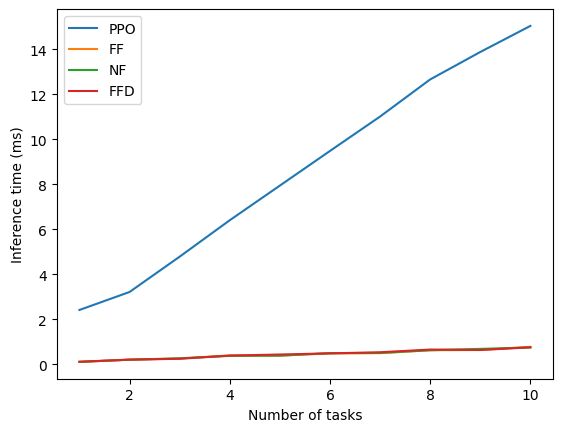

In [17]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['inference_time'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['inference_time'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['inference_time'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['inference_time'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Inference time (ms)')
plt.legend()
plt.show()

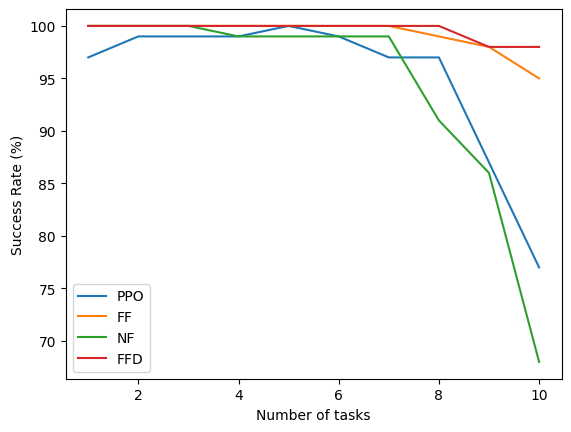

In [18]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['success'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['success'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['success'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['success'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Success Rate (%)')
plt.legend()
plt.show()

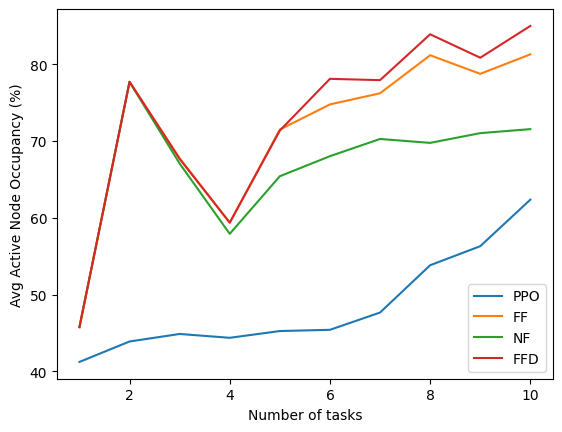

In [19]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Avg Active Node Occupancy (%)')
plt.legend()
plt.show()

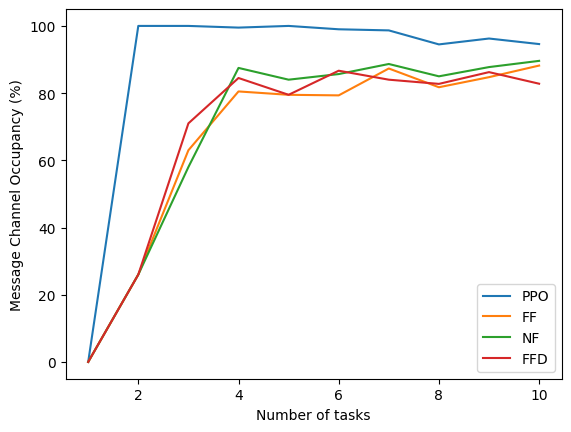

In [20]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['message_channel_occupancy'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['message_channel_occupancy'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['message_channel_occupancy'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['message_channel_occupancy'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Message Channel Occupancy (%)')
plt.legend()
plt.show()

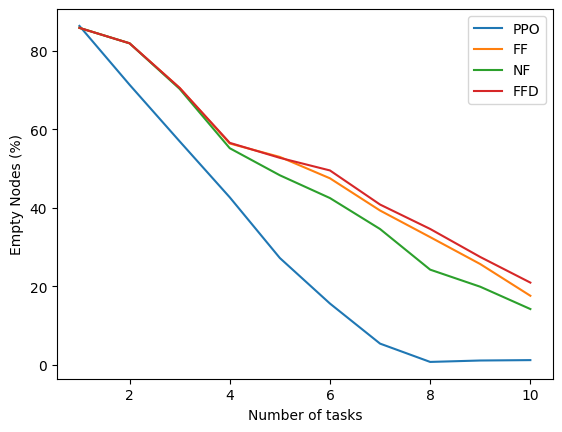

In [21]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['empty_nodes'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['empty_nodes'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['empty_nodes'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['empty_nodes'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Empty Nodes (%)')
plt.legend()
plt.show()